# Logistic Regression Optimization

This notebook is designed to show the multiple outcomes we can get from the Logistic Regression. We will focus on the small details we have to pay attention to take the most of this technique. We will try different kinds of regularization, regularization parameters and prepr

## Imports 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

## Parameters

In [2]:
raw_data_path = "../data/raw/"
interim_data_path = "../data/iterim"
processed_data_path = "../data/processed/"
submissions_data_path = "../data/submissions/"

In [3]:
train_data_path = raw_data_path + "cs-training.csv"
test_data_path = raw_data_path + "cs-test.csv"
sample_submission_path = raw_data_path + "sampleEntry.csv"
data_dictionary_path = raw_data_path + "Data Dictionary.xls"

In [4]:
target_column = "SeriousDlqin2yrs"

In [5]:
N_JOBS = 4

## Loading things

### Train data

In [6]:
train_data = pd.read_csv(train_data_path, index_col=0)

In [7]:
train_data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [8]:
train_data.shape

(150000, 11)

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


### Test data path

In [10]:
test_data = pd.read_csv(test_data_path, index_col=0)

In [11]:
test_data.shape

(101503, 11)

In [12]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101503 entries, 1 to 101503
Data columns (total 11 columns):
SeriousDlqin2yrs                        0 non-null float64
RevolvingUtilizationOfUnsecuredLines    101503 non-null float64
age                                     101503 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    101503 non-null int64
DebtRatio                               101503 non-null float64
MonthlyIncome                           81400 non-null float64
NumberOfOpenCreditLinesAndLoans         101503 non-null int64
NumberOfTimes90DaysLate                 101503 non-null int64
NumberRealEstateLoansOrLines            101503 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    101503 non-null int64
NumberOfDependents                      98877 non-null float64
dtypes: float64(5), int64(6)
memory usage: 9.3 MB


### Sample Submission

In [13]:
sample_submission = pd.read_csv(sample_submission_path)

In [14]:
sample_submission.head()

,Id,Probability
0,1,0.080807
1,2,0.040719
2,3,0.011968
3,4,0.067640
4,5,0.108264


In [15]:
sample_submission.shape

(101503, 2)

In [16]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 2 columns):
Id             101503 non-null int64
Probability    101503 non-null float64
dtypes: float64(1), int64(1)
memory usage: 1.5 MB


### Data Dictionary

In [17]:
data_dictionary = pd.read_excel(data_dictionary_path, header=1)

In [18]:
data_dictionary

,Variable Name,Description,Type
0,SeriousDlqin2yrs,Person experienced 90 days past due delinquenc...,Y/N
1,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lin...,percentage
2,age,Age of borrower in years,integer
3,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days p...,integer
4,DebtRatio,"Monthly debt payments, alimony,living costs di...",percentage
5,MonthlyIncome,Monthly income,real
6,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loa...,integer
7,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or m...,integer
8,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans inclu...,integer
9,NumberOfTime60-89DaysPastDueNotWorse,Number of times borrower has been 60-89 days p...,integer


## Exploratory data analysis

With this section I want to show that features vary and may need specific treatment.

### General dataset description

In [19]:
train_data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


#### Mean Plot

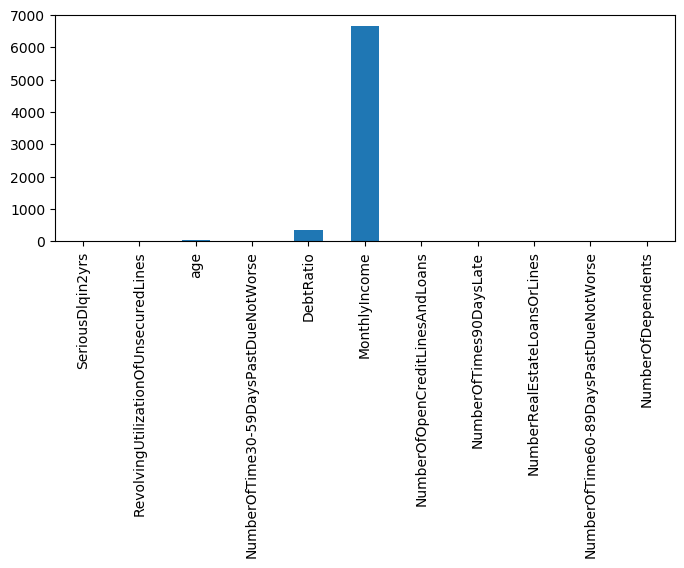

In [20]:
f, ax = plt.subplots(figsize=(8, 3), dpi=100)
train_data.describe().loc["mean", :].plot(kind="bar")

#### Std plot

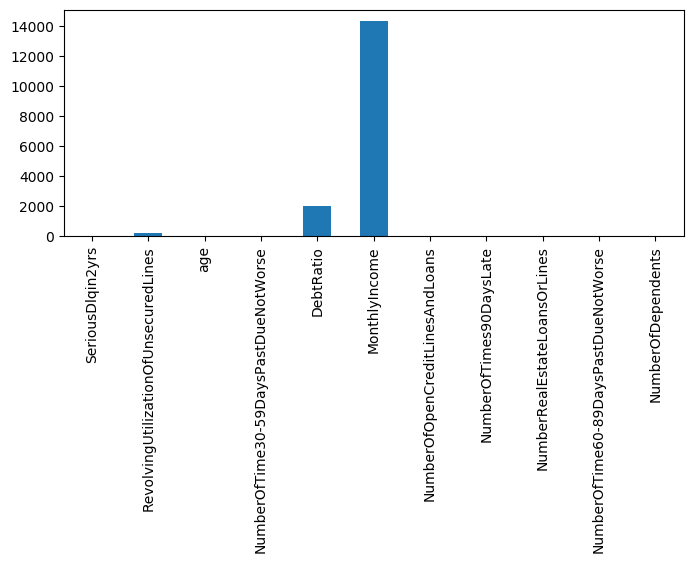

In [21]:
f, ax = plt.subplots(figsize=(8, 3), dpi=100)
train_data.describe().loc["std", :].plot(kind="bar")

### Target

In [22]:
train_data[target_column].mean()

0.06684

As we can see from the number above the target has a very low rate of events.

### Nan Presence

In [23]:
train_data.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

As a detailed treatment of missing data is not the subject of this notebook I will make a naive approach by filling all nan with zeros.

In [24]:
train_data = train_data.fillna(0)

## Train Test Split

To make a fair comparison with all models, we will split the whole datase into two set: optimization and validation. All CV steps and hyperparemeters search will be performed in the optimizaion set, and all and the same validation dataset will be used to extract performance metrics. As a benchmark I will use the Dummy Classifier which predicts random values with the same ration present in the training set.

In [25]:
(X_optimization, X_validation,
 y_optimization, y_validation) = train_test_split(train_data.drop([target_column], axis=1),
                                                  train_data[target_column])

In [26]:
print(X_optimization.shape, X_validation.shape, y_optimization.shape, y_validation.shape)

(112500, 10) (37500, 10) (112500,) (37500,)


## Metrics

To make a general discussion I will take some popular metrics.

In [27]:
metrics_dict = {
    #"accuracy": accuracy_score,
    "roc_auc": roc_auc_score
}

In [28]:
results = []

## Models

### Dummy Classifier

In [29]:
dummy_classifier = DummyClassifier()

In [30]:
dummy_classifier.fit(X_optimization, y_optimization)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [31]:
y_dummy = dummy_classifier.predict(X_validation)

In [32]:
dummy_results = dict({
    key: function(y_validation, y_dummy) for key, function in metrics_dict.items()
}, **{"model": "dummy"})

In [33]:
dummy_results

{'roc_auc': 0.4993550538546697, 'model': 'dummy'}

In [34]:
results.append(dummy_results)

### Plain Logistic Regression

In [35]:
plain_lr = LogisticRegression(C=1e30)

In [36]:
%%time
plain_lr.fit(X_optimization, y_optimization)

/home/otaviocv/.anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 1.63 s, sys: 35.4 ms, total: 1.66 s
Wall time: 1.66 s


LogisticRegression(C=1e+30, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
y_proba_plain_lr = plain_lr.predict_proba(X_validation)

In [38]:
plain_lr_results = dict({
    key: function(y_validation, y_proba_plain_lr[:, 1]) for key, function in metrics_dict.items()
}, **{"model": "plain_logistic_regression"})

In [39]:
plain_lr_results

{'roc_auc': 0.6963696531619897, 'model': 'plain_logistic_regression'}

In [40]:
results.append(plain_lr_results)

### Plain Logistic Regression with scaling

In [41]:
plain_lr_with_scal = Pipeline([
    ("preprocessing", StandardScaler()),
    ("estimator", LogisticRegression(C=1e30))
])


In [42]:
%%time
plain_lr_with_scal.fit(X_optimization, y_optimization)

/home/otaviocv/.anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 1.27 s, sys: 43.3 ms, total: 1.31 s
Wall time: 573 ms


Pipeline(memory=None,
         steps=[('preprocessing',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('estimator',
                 LogisticRegression(C=1e+30, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [43]:
y_proba_plain_lr_with_scal = plain_lr_with_scal.predict_proba(X_validation)

In [44]:
plain_lr_with_scal_results = dict({
    key: function(y_validation, y_proba_plain_lr_with_scal[:, 1]) 
    for key, function in metrics_dict.items()
}, **{"model": "logistic_regression_with_scaling"})

In [45]:
plain_lr_with_scal_results

{'roc_auc': 0.6961972231040608, 'model': 'logistic_regression_with_scaling'}

In [46]:
results.append(plain_lr_with_scal_results)

### L2 Logistic Regression

In [47]:
l2_lr = Pipeline([
    ("estimator", LogisticRegression(C=1e30))
])

l2_hyperparameters = {
    "estimator__C": [10**i for i in range(-1, 20)]
}

In [48]:
%%time
l2_opt = GridSearchCV(l2_lr,
                      l2_hyperparameters,
                      cv=5,
                      scoring="roc_auc",
                      n_jobs=N_JOBS,
                      refit=True,
                      verbose=10)

CPU times: user 99 µs, sys: 6 µs, total: 105 µs
Wall time: 115 µs


In [49]:
l2_opt.fit(X_optimization, y_optimization)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   14.8s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   18.9s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   23.5s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   27.9s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   33.2s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   39.4s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   45.4s
[Parallel(n_jobs=4)]: Done 105 out of 105 | elapsed:   51.7s finished
/home/otaviocv/.anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('estimator',
                                        LogisticRegression(C=1e+30,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='warn',
                                                           n_jobs=None,
                                                           penalty='l2',
                                                           random_state=None,
                         

In [50]:
l2_opt.best_estimator_

Pipeline(memory=None,
         steps=[('estimator',
                 LogisticRegression(C=10000, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [51]:
y_proba_l2 = l2_opt.predict_proba(X_validation)

In [52]:
l2_results = dict({
    key: function(y_validation, y_proba_l2[:, 1]) 
    for key, function in metrics_dict.items()
}, **{"model": "l2_logistic_regression"})

In [53]:
l2_results

{'roc_auc': 0.6962495912603549, 'model': 'l2_logistic_regression'}

In [54]:
results.append(l2_results)

### L2 Logistic Regression with scaling

In [55]:
l2_lr_with_scal = Pipeline([
    ("preprocessing", StandardScaler()),
    ("estimator", LogisticRegression())
])

l2_hyperparameters = {
    "estimator__C": [10**i for i in range(-20, 20)]
}

In [56]:
%%time
l2_with_scal_opt = GridSearchCV(l2_lr_with_scal,
                      l2_hyperparameters,
                      cv=5,
                      scoring="roc_auc",
                      n_jobs=N_JOBS,
                      refit=True,
                      verbose=10)

CPU times: user 53 µs, sys: 4 µs, total: 57 µs
Wall time: 63.2 µs


In [57]:
l2_with_scal_opt.fit(X_optimization, y_optimization)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   15.3s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   19.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   24.5s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:   29.5s
[Parallel(

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('estimator',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           mult

In [58]:
l2_with_scal_opt.best_estimator_

Pipeline(memory=None,
         steps=[('preprocessing',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('estimator',
                 LogisticRegression(C=1e-17, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [59]:
y_proba_l2_with_scal = l2_with_scal_opt.predict_proba(X_validation)

In [60]:
l2_with_scal_results = dict({
    key: function(y_validation, y_proba_l2_with_scal[:, 1]) 
    for key, function in metrics_dict.items()
}, **{"model": "l2_logistic_regression_with_scaling"})

In [61]:
l2_with_scal_results

{'roc_auc': 0.7117845727535034, 'model': 'l2_logistic_regression_with_scaling'}

In [62]:
results.append(l2_with_scal_results)

### L1 Logistic Regression

In [63]:
l1_lr = Pipeline([
    ("estimator", LogisticRegression(penalty='l1'))
])

l1_hyperparameters = {
    "estimator__C": [10**i for i in range(-20, 20)]
}

In [64]:
%%time
l1_opt = GridSearchCV(l1_lr,
                      l1_hyperparameters,
                      cv=5,
                      scoring="roc_auc",
                      n_jobs=N_JOBS,
                      refit=True,
                      verbose=10)

CPU times: user 20 µs, sys: 2 µs, total: 22 µs
Wall time: 25 µs


In [65]:
l1_opt.fit(X_optimization, y_optimization)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.1702s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Batch computation too slow (2.1450s.) Setting batch_size=1.
[Parallel(n_jobs=4)]: Done  98 tasks      | elapsed:   12.5s
[Parallel(n_jobs=4)]: Done 113 tasks      | elapsed:   27.0s
[Parallel(n_jobs=4)]: Done 126 tasks      | elapsed:   36.6s
[Parallel(n_jobs=4)]: Done 139 tasks      | elapsed:   46.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   58.8s
[Parallel(n_jobs=4)]: Done 169 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 18

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('estimator',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='warn',
                                                           n_jobs=None,
                                                           penalty='l1',
                                                           random_state=None,
                           

In [66]:
l1_opt.best_estimator_

Pipeline(memory=None,
         steps=[('estimator',
                 LogisticRegression(C=1000000, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [67]:
y_proba_l1 = l1_opt.predict_proba(X_validation)

In [68]:
l1_results = dict({
    key: function(y_validation, y_proba_l1[:, 1]) 
    for key, function in metrics_dict.items()
}, **{"model": "l1_logistic_regression"})

In [69]:
l1_results

{'roc_auc': 0.6970173368377999, 'model': 'l1_logistic_regression'}

In [70]:
results.append(l1_results)

### L1 Logistic Regression with scaling

In [71]:
l1_lr_with_scal = Pipeline([
    ("preprocessing", StandardScaler()),
    ("estimator", LogisticRegression(penalty='l1'))
])

l1_hyperparameters = {
    "estimator__C": [10**i for i in range(-20, 20)]
}

In [72]:
%%time
l1_with_scal_opt = GridSearchCV(l1_lr_with_scal,
                      l1_hyperparameters,
                      cv=5,
                      scoring="roc_auc",
                      n_jobs=N_JOBS,
                      refit=True,
                      verbose=10)

CPU times: user 43 µs, sys: 3 µs, total: 46 µs
Wall time: 51.7 µs


In [73]:
l1_with_scal_opt.fit(X_optimization, y_optimization)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:  6.4min
[Parallel(

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('estimator',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           mult

In [74]:
l1_with_scal_opt.best_estimator_

Pipeline(memory=None,
         steps=[('preprocessing',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('estimator',
                 LogisticRegression(C=0.01, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [75]:
y_proba_l1_with_scal = l1_with_scal_opt.predict_proba(X_validation)

In [76]:
l1_with_scal_results = dict({
    key: function(y_validation, y_proba_l1_with_scal[:, 1]) 
    for key, function in metrics_dict.items()
}, **{"model": "l1_logistic_regression_with_scaling"})

In [77]:
l1_with_scal_results

{'roc_auc': 0.6968167984125164, 'model': 'l1_logistic_regression_with_scaling'}

In [78]:
results.append(l1_with_scal_results)

### Elastic Net Logistic Regression

In [79]:
elastic_net = Pipeline([
    ("estimator", ElasticNet())
])

elastic_net_hyperparameters = {
    "estimator__alpha": np.logspace(1e-10, 1e10, 30),
    "estimator__l1_ratio": np.linspace(0.01, 0.95, 10)
}

/home/otaviocv/.anaconda3/lib/python3.7/site-packages/numpy/core/function_base.py:279: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)


In [80]:
%%time
elastic_net_opt = GridSearchCV(elastic_net,
                      elastic_net_hyperparameters,
                      cv=5,
                      scoring="roc_auc",
                      n_jobs=N_JOBS,
                      refit=True,
                      verbose=10)

CPU times: user 58 µs, sys: 4 µs, total: 62 µs
Wall time: 69.9 µs


In [ ]:
elastic_net_opt.fit(X_optimization, y_optimization)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=4)]: Batch computation too fast (0.1381s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Batch computation too slow (2.3889s.) Setting batch_size=1.
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:   12.2s
[Parallel(n_jobs=4)]: Done  71 tasks      | elapsed:   32.2s
[Parallel(n_jobs=4)]: Done  82 tasks      | elapsed:   44.5s
[Parallel(n_jobs=4)]: Done  93 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 106 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 119 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 134 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 149 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 166 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 183 tasks      |

In [ ]:
elastic_net_opt.best_estimator_

In [ ]:
y_proba_elastic_net = elastic_net_opt.predict_proba(X_validation)

In [ ]:
elastic_net_results = dict({
    key: function(y_validation, y_proba_elsatic_net[:, 1]) 
    for key, function in metrics_dict.items()
}, **{"model": "elastic_net"})

In [ ]:
elastic_net_results

In [ ]:
results.append(elastic_net_results)

### Elastic Net Logistic Regression with scaling

In [ ]:
elastic_net_with_scal = Pipeline([
    ("preprocessing", StandardScaler()),
    ("estimator", ElasticNet())
])

elastic_net_hyperparameters = {
    "estimator__alpha": np.logspace(1e-10, 1e10, 30),
    "estimator__l1_ratio": np.linspace(0.01, 0.95, 10)
}

In [ ]:
%%time
elastic_net_with_scal_opt = GridSearchCV(elastic_net_with_scal,
                      elastic_net_hyperparameters,
                      cv=5,
                      scoring="roc_auc",
                      n_jobs=2,
                      refit=True,
                      verbose=10)

In [ ]:
elastic_net_with_scal_opt.fit(X_optimization, y_optimization)

In [ ]:
elastic_net_with_scal_opt.best_estimator_

In [ ]:
y_proba_elastic_net_with_scal = elastic_net_with_scal_opt.predict_proba(X_validation)

In [ ]:
elastic_net_with_scal_results = dict({
    key: function(y_validation, y_proba_elastic_net_with_scal[:, 1]) 
    for key, function in metrics_dict.items()
}, **{"model": "elastic_net_with_scaling"})

In [ ]:
elastic_net_with_scal_results

In [ ]:
results.append(elastic_net_with_scal_results)

## Results Comparison

In [ ]:
pd.DataFrame(results)

## Weights Comparison